In [1]:
import numpy as np
import tifffile
import math
from collections import Counter
import json
import os
from pykowski.karambola import KarambolaResults
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Porestats(object):
    def __init__(self, data):
        self.name = data["name"]
        
        self.porosity = data["porosity"]
        self.porosity_sq = self.porosity*self.porosity
        
        #Covariance: C(x) = cov(x)+Vv^2
        self.covariance_x = np.array(data["x"])
        self.covariance_y =  np.array(data["y"])
        self.covariance_z =  np.array(data["z"])
        
        self.covariance_averaged = np.array(data["averaged"])
        
        #Covariance Function: cov(x) = C(x)-Vv^2
        self.covariance_function_x = self.covariance_x-self.porosity_sq
        self.covariance_function_y = self.covariance_y-self.porosity_sq
        self.covariance_function_z = self.covariance_z-self.porosity_sq
        
        self.covariance_function_averaged = self.covariance_averaged-self.porosity_sq
        
        #Normalized Covariance Function: cov(x)/(Vv-Vv^2)
        self.normalized_covariance_x = np.divide(self.covariance_function_x, self.porosity-self.porosity_sq)
        self.normalized_covariance_y = np.divide(self.covariance_function_y, self.porosity-self.porosity_sq)
        self.normalized_covariance_z = np.divide(self.covariance_function_z, self.porosity-self.porosity_sq)
        
        self.normalized_covariance_averaged = np.divide(self.covariance_function_averaged, self.porosity-self.porosity_sq)
        
        self.fit_x = None
        self.fit_y = None
        self.fit_z = None
        
        self.fit_averaged = None
        
        self.poly_x = None
        self.poly_y = None
        self.poly_z = None
        
        self.poly_averaged = None
        
        self.fit_poly()
        
    def fit_poly(self, N=10, res=1):
        self.fit_x = np.polyfit(np.array(range(len(self.covariance_x[0:N])))*res, self.covariance_x[0:N], 1)
        self.poly_x = np.poly1d(self.fit_x)
        
        self.fit_y = np.polyfit(np.array(range(len(self.covariance_y[0:N])))*res, self.covariance_y[0:N], 1)
        self.poly_y = np.poly1d(self.fit_y)
        
        self.fit_z = np.polyfit(np.array(range(len(self.covariance_z[0:N])))*res, self.covariance_z[0:N], 1)
        self.poly_z = np.poly1d(self.fit_z)
        
        self.fit_averaged = np.polyfit(np.array(range(len(self.covariance_averaged[0:N])))*res, self.covariance_averaged[0:N], 1)
        self.poly_averaged = np.poly1d(self.fit_averaged)
        
        self.rc_x = (self.porosity_sq-self.porosity)/self.poly_x[1]
        self.rc_y = (self.porosity_sq-self.porosity)/self.poly_y[1]
        self.rc_z = (self.porosity_sq-self.porosity)/self.poly_z[1]
        
        self.rc_averaged = (self.porosity_sq-self.porosity)/self.poly_averaged[1]
    
    def compute_Sv(self, resolution=1., direc_frac=[1., 1., 1.]):
        self.Sv_i = [-2./direc_frac[0]*self.poly_x[1]*1./resolution, -2./direc_frac[1]*self.poly_y[1]*1./resolution, -2./direc_frac[2]*self.poly_z[1]*1./resolution]
        self.Sv_average = -4*self.poly_averaged[1]*1./resolution
        
    def compute_kozeny_carman_perm(self):
        self.kozeny_i = [(self.porosity**3)/((1-self.porosity)**2)*1./(val**2) for val in self.Sv_i]
        self.kozeny_average = (self.porosity**3)/((1-self.porosity)**2)*1./(self.Sv_average**2) 
        
    def compute_kozeny_constant(self, permeability):
        self.kozeny_c_i = [kozeny/perm for kozeny, perm in zip(self.kozeny_i, permeability)]
        self.kozeny_c_average = self.kozeny_average/np.mean(permeability)

In [50]:
names = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "C1", "C2", "Berea",
         "Isotropic12", "Isotropic13", "Isotropic14", "Anisotropic121214", "Anisotropic131314",
         "beadpack", "ketton","bentheimer", "estaillades", "doddington"]

In [51]:
resolution_file = "image_data/resolutions.json"
with open(resolution_file) as data_file:
    resolutions = json.load(data_file)
    
dimensions_file = "image_data/dimensions.json"
with open(dimensions_file) as data_file:
    dimensions = json.load(data_file)
    
permeability_file = "permeability_results/permeability_tensors_edit.json"
with open(permeability_file) as data_file:
    permeability = json.load(data_file)
    
interface_results_dir = "interface_results/"
interface_data = {}

for file in os.listdir(interface_results_dir):
        if file.endswith(".json"):
            with open(interface_results_dir+file) as data_file:
                data = json.load(data_file)
                interface_data[data["name"]] = data
                
covariance_results_dir = "covariance_results/"
porestats_objs = {}

for file in os.listdir(covariance_results_dir):
        if file.endswith(".json"):
            with open(covariance_results_dir+file) as data_file:
                data = json.load(data_file)
                porestats_objs[data["name"]] = Porestats(data)

                
minkowski_data = {}
for sample_name in names:
    minkowski_data[sample_name] = {}
    
    json_files = []
    
    for file in os.listdir("minkowski_results/karambola_output/"+sample_name):
        if file.endswith(".json"):
            json_files.append(file)

    dxs = []
    results = []
    for file_name in json_files:
        data = None
        with open("minkowski_results/karambola_output/"+sample_name+"/"+file_name, 'r') as f:
            for row in f:
                data = row
        name = file_name.split("_")
        dx = int(name[0])
        json_data = json.loads(data)
        karam_res = KarambolaResults()
        karam_res.load_from_json_format(json_data)
        #if karam_res.w202 is not 'ERROR' and karam_res.w102 is not 'ERROR':
        try:
            karam_res.compute_eigenvalues()
            dxs.append(dx)
            results.append(karam_res)
        except:
            print "Non-Manifold mesh in "+file_name

    w102s =  [x.w102 for x in results]
    w100s = [x.w100 for x in results]
    beta_102s = [x.beta_102 for x in results]
    beta_202s = [x.beta_202 for x in results]
    gamma_102s = [x.gamma_102 for x in results]
    gamma_202s = [x.gamma_202 for x in results]

    dxs_sorted = sorted(dxs)
    
    w102s_sorted = [x for (y,x) in sorted(zip(dxs, w102s))]
    w100s_sorted = [x for (y,x) in sorted(zip(dxs, w100s))]
    
    beta_102s_sorted = [x for (y,x) in sorted(zip(dxs, beta_102s))]
    beta_202s_sorted = [x for (y,x) in sorted(zip(dxs, beta_202s))]
    gamma_102s_sorted = [x for (y,x) in sorted(zip(dxs, gamma_102s))]
    gamma_202s_sorted = [x for (y,x) in sorted(zip(dxs, gamma_202s))]
    minkowski_data[sample_name]["dx"] = dxs_sorted
    minkowski_data[sample_name]["beta_102"] = beta_102s_sorted
    minkowski_data[sample_name]["beta_202"] = beta_202s_sorted
    minkowski_data[sample_name]["gamma_102"] = gamma_102s
    minkowski_data[sample_name]["gamma_202"] = gamma_202s
    minkowski_data[sample_name]["w100"] = w100s_sorted
    minkowski_data[sample_name]["w102"] = w102s_sorted

In [52]:
bear_results = {}
for name in names:
    bear_results[name] = {}
    print name
    im = tifffile.imread("image_data/images/"+name+".tif")
    res = resolutions[name]
    dim = dimensions[name]
    porosity = porestats_objs[name].porosity
    
    #Compute Volume and equivalent radius
    Vo = (dim*res)**3
    So = float(6*(dim*dim))*res*res
    V_alpha = Vo*porosity
    R_eq = np.power(3.*Vo/4.*1./np.pi, 1./3.)
    
    S_alpha_beta = 3*res*res*minkowski_data[name]["w100"][-1]
    
    print "Volume Area: ", So
    print "Pore Grain Area: ", S_alpha_beta
    
    #compute orientation term
    normed_w102 = (minkowski_data[name]["w102"][-1]/minkowski_data[name]["w100"][-1])
    print normed_w102
    print "Alpha_ij^-1"

    alpha_ij_upper =  np.identity(3)-normed_w102
    print alpha_ij_upper
    alpha_ij_over_upper = np.linalg.inv(alpha_ij_upper)
    

    print "Porosity: ", porosity


    specific_area_pores = S_alpha_beta/Vo  
    
    print "Specific Area Pores: ", specific_area_pores
    kozeny_factor = 1.
    kij_upper = (porosity*porosity*porosity)/  \
                (kozeny_factor*(specific_area_pores*specific_area_pores)) \
                *alpha_ij_over_upper#np.multiply(alpha_ij_over_upper, tort_fac)
    print "Bear 1990 Permeability"
    print kij_upper

    k_measured =  np.array([[permeability[name]["kx"], 0., 0.],
                            [0., permeability[name]["ky"], 0.], 
                            [0., 0., permeability[name]["kz"]]])
    print "Measured Permeability"
    print k_measured
    print ""
    
    print "Tortuosity Factors"
    factor = np.divide(kij_upper, k_measured)
    print factor
    print 1./porosity
    print ""
    print "Check Permeability"
    print kij_upper*1./factor
    print ""
    print ""
    
    print "Average Permeability: ", np.mean([k_measured[0][0], k_measured[1][1], k_measured[0][0]])
    print "Kozeny Permeability: ", (porosity**3)/((specific_area_pores**2))
    bear_results[name]["porosity"] = porosity
    bear_results[name]["specific_surface_area"] = specific_area_pores
    bear_results[name]["x_factor"] = factor[0][0]
    bear_results[name]["y_factor"] = factor[1][1]
    bear_results[name]["z_factor"] = factor[2][2]

S1
Volume Area:  4.071302406e-05
Pore Grain Area:  0.000125941157683
[[  2.86698629e-01   3.20890961e-04   4.65074571e-03]
 [  3.20890961e-04   2.94626874e-01  -4.58485870e-03]
 [  4.65074571e-03  -4.58485870e-03   4.18674497e-01]]
Alpha_ij^-1
[[  7.13301371e-01  -3.20890961e-04  -4.65074571e-03]
 [ -3.20890961e-04   7.05373126e-01   4.58485870e-03]
 [ -4.65074571e-03   4.58485870e-03   5.81325503e-01]]
Porosity:  0.141302777778
Specific Area Pores:  7125.15824048
Bear 1990 Permeability
[[  7.79135039e-11   3.13947431e-14   6.23079414e-13]
 [  3.13947431e-14   7.87891645e-11  -6.21151446e-13]
 [  6.23079414e-13  -6.21151446e-13   9.56067584e-11]]
Measured Permeability
[[  1.96900000e-12   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.75200000e-12   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.31200000e-12]]

Tortuosity Factors
[[ 39.57008831          inf          inf]
 [         inf  44.97098432         -inf]
 [         inf         -inf  72.87100489]]
7.07700171028

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import spearmanr

In [54]:
x_factors = []
y_factors = []
z_factors = []
porosities = []
samples_names_label = []
ratio = []
minkowski_ratio = []
specific_surface_areas = []
measured_permeability_ratios = []
average_perms = []
min_perms = []
max_perms = []
for name, vals in bear_results.iteritems():
    if name not in ["Isotropic12", "Isotropic13", "Isotropic14", "Anisotropic121214", "Anisotropic131314"]:
        samples_names_label.append(name)
        x_factors.append(vals["x_factor"])
        y_factors.append(vals["y_factor"])
        z_factors.append(vals["z_factor"])
        porosities.append(vals["porosity"])
        ratio.append(min([vals["x_factor"],vals["y_factor"], vals["z_factor"]])/(max([vals["x_factor"],vals["y_factor"], vals["z_factor"]])))
        specific_surface_areas.append(vals["specific_surface_area"])
        minkowski_ratio.append(minkowski_data[name]["beta_102"][-1])
        min_perm = min([permeability[name]["kx"], permeability[name]["ky"], permeability[name]["kz"]])
        max_perm = max([permeability[name]["kx"], permeability[name]["ky"], permeability[name]["kz"]])
        min_perms.append(min_perm)
        max_perms.append(max_perms)
        average_perms.append(np.mean([permeability[name]["kx"], permeability[name]["ky"], permeability[name]["kz"]]))
        measured_permeability_ratios.append(min_perm/max_perm)

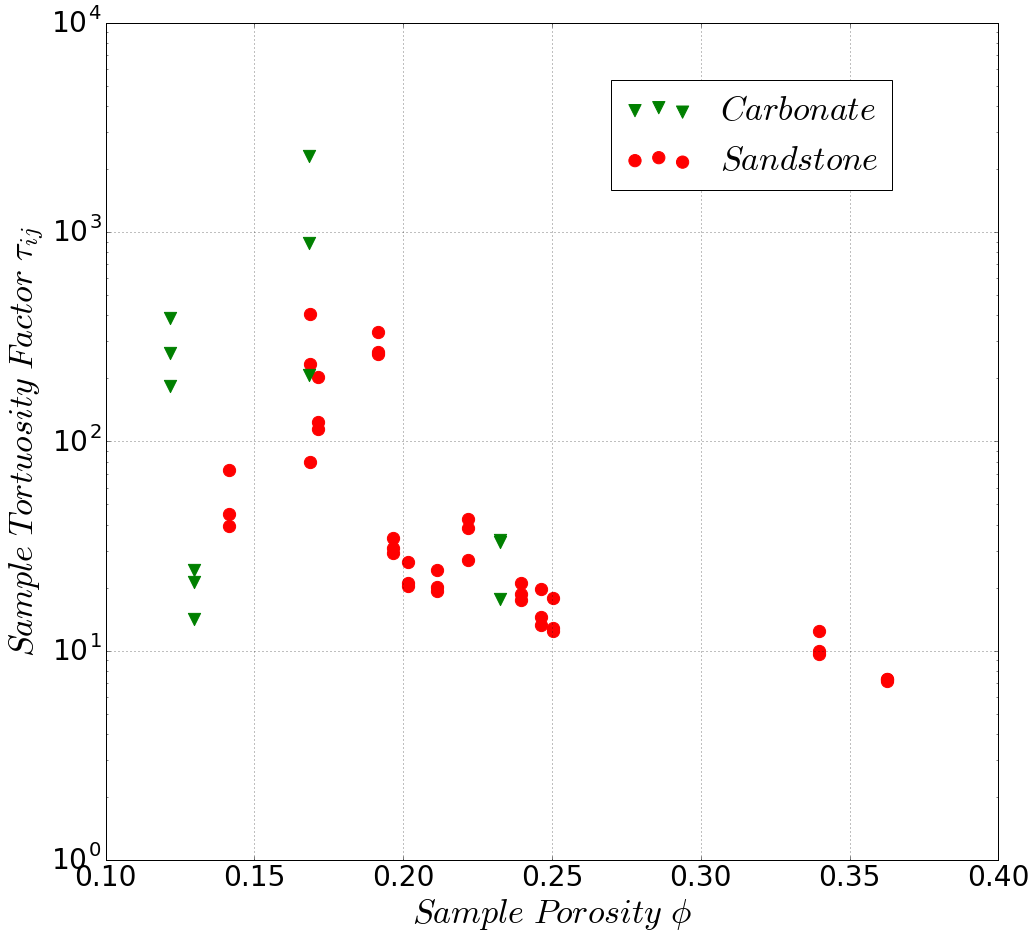

In [55]:
fig, ax = plt.subplots(figsize=(16,15))

ax.set_yscale("log")

ax.set_xlabel(r'$Sample \ Porosity \ \phi$', fontsize=34)
ax.set_ylabel(r'$Sample \ Tortuosity \ Factor \ \tau_{ij}$', fontsize=34)

plt.grid()

for name, vals in bear_results.iteritems():
    color = "red"
    if name not in ["Isotropic12", "Isotropic13", "Isotropic14", "Anisotropic121214", "Anisotropic131314"]:
        if name in ["ketton", "estaillades", "C1", "C2"]:
            color = "green"
            marker = "v"
        else:
            marker = "o"
        if name == "estaillades":
            ax.scatter(vals["porosity"], vals["x_factor"],  s=150,color= color, label=r"$Carbonate$", marker=marker)
            ax.scatter(vals["porosity"], vals["y_factor"],  s=150,color= color, marker=marker)
            ax.scatter(vals["porosity"], vals["z_factor"],  s=150,color= color, marker=marker)
        elif name == "doddington":
            ax.scatter(vals["porosity"], vals["x_factor"],  s=150,color= color, label=r"$Sandstone$", marker=marker)
            ax.scatter(vals["porosity"], vals["y_factor"],  s=150,color= color, marker=marker)
            ax.scatter(vals["porosity"], vals["z_factor"],  s=150,color= color, marker=marker)
        else:
            ax.scatter(vals["porosity"], vals["x_factor"],  s=150,color= color, marker=marker)
            ax.scatter(vals["porosity"], vals["y_factor"],  s=150,color= color, marker=marker)
            ax.scatter(vals["porosity"], vals["z_factor"],  s=150,color= color, marker=marker)

for i, (item) in enumerate(ax.get_xticklabels()):
    item.set_fontsize(28)

for i, (item) in enumerate(ax.get_yticklabels()):
    item.set_fontsize(28)

legend = plt.legend(bbox_to_anchor=(0., 0.85, 0.9, .102), fontsize=34)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')

#print spearmanr(porosities, measured_permeability_ratios)
fig.savefig("permeability_results/tortuosity_factor_vs_porosity.png", bbox_extra_artists=(legend,), bbox_inches='tight', dpi=300)
plt.show()

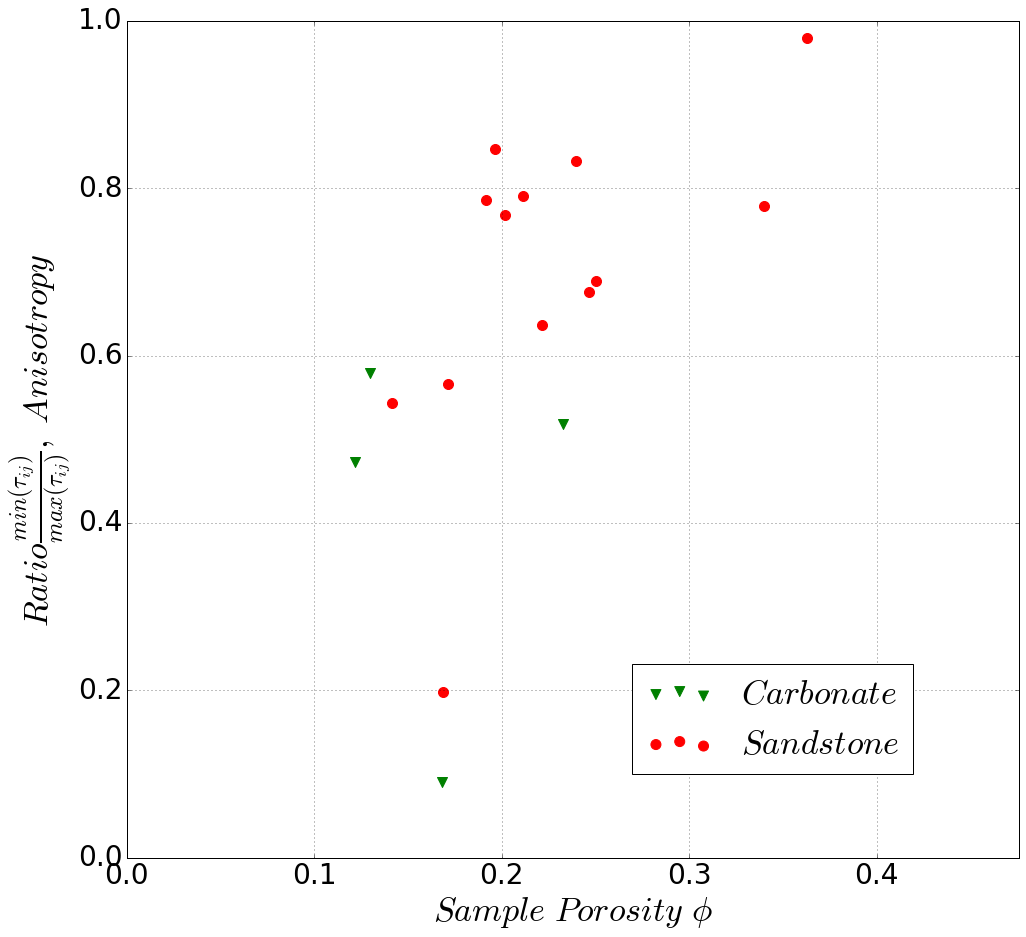

In [56]:
fig, ax = plt.subplots(figsize=(16,15))

#ax.set_yscale("log")
ax.set_xlim(0, 0.476)
ax.set_ylim(0.0, 1.0)

#ax.set_title(r'$Anisotropy \ Indices \ \beta_{1}^{0,2}, \ \beta_{2}^{0,2}  \ versus \ Window \ Size \ r$', fontsize=22, y=1.02)#

ax.set_xlabel(r'$Sample \ Porosity \ \phi$', fontsize=34)
ax.set_ylabel(r'$Ratio \frac{min(\tau_{ij})}{max(\tau_{ij})}, \ Anisotropy$', fontsize=34)

plt.grid()

for por, rat, name in zip(porosities, ratio, samples_names_label):
    color = "red"
    if name in ["ketton", "estaillades", "C1", "C2"]:
        color = "green"
        marker = "v"
    else:
        marker = "o"
    if name == "estaillades":
        ax.scatter(por, rat, color=color, s=100, label=r"$Carbonate$", marker=marker)
    elif name == "doddington":
        ax.scatter(por, rat, color=color, s=100, label=r"$Sandstone$", marker=marker)
    else:
        ax.scatter(por, rat, color=color, s=100, marker=marker)
for i, (item) in enumerate(ax.get_xticklabels()):
    item.set_fontsize(28)

for i, (item) in enumerate(ax.get_yticklabels()):
    item.set_fontsize(28)
    
    
#ax.plot(np.linspace(0, 0.476, 100), 0.5+np.linspace(0, 0.476, 100), color="black", linestyle="--", linewidth=3)

legend = plt.legend(bbox_to_anchor=(0., 0.15, 0.9, .102), fontsize=34)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
fig.savefig("permeability_results/tortuosity_anisotropy_vs_porosity.png", bbox_extra_artists=(legend,), bbox_inches='tight', dpi=300)
plt.show()

In [57]:
import statsmodels.api as sm

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     4.276
Date:                Wed, 24 Aug 2016   Prob (F-statistic):             0.0564
Time:                        15:29:01   Log-Likelihood:                 2.4545
No. Observations:                  17   AIC:                           -0.9089
Df Residuals:                      15   BIC:                            0.7575
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0439      0.367     -0.119      0.9

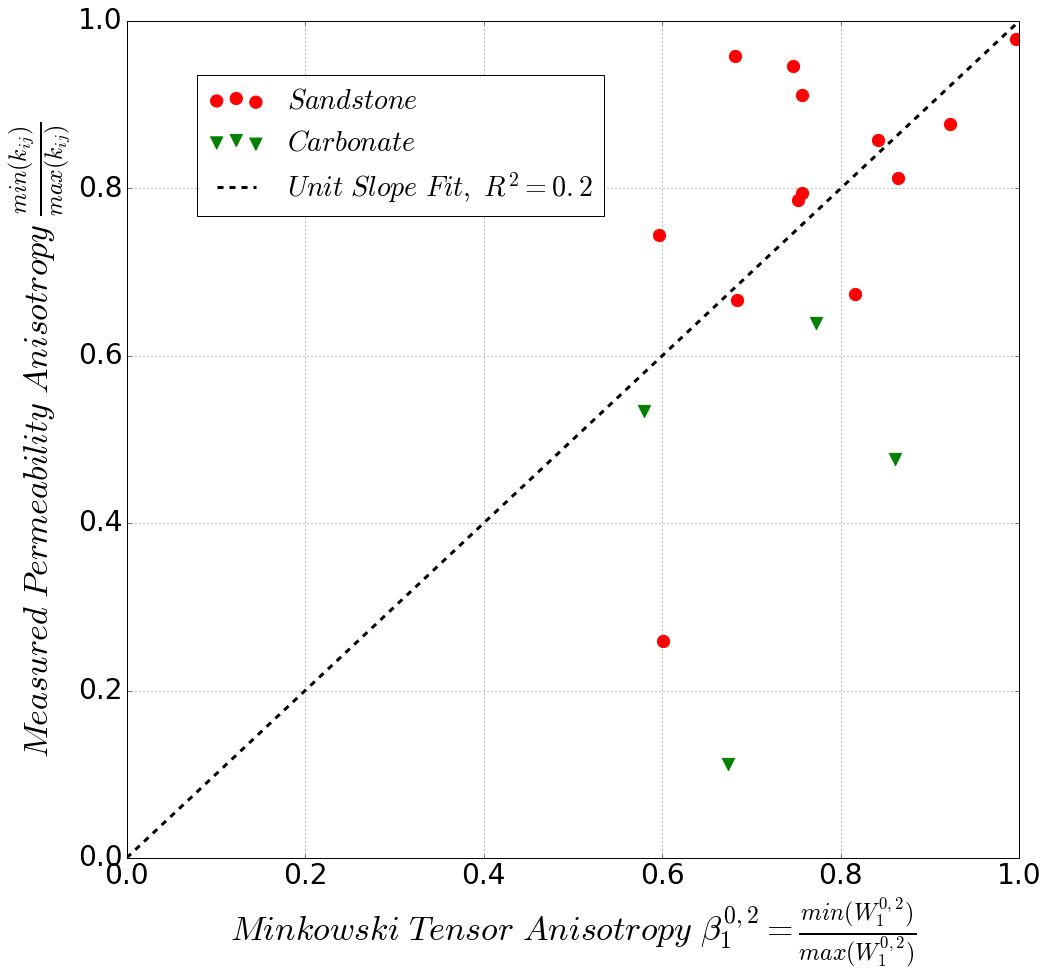

In [82]:
fig, ax = plt.subplots(figsize=(16,15))

#ax.set_yscale("log")
ax.set_xlim(0, 1.0)
ax.set_ylim(0.0, 1.0)

#ax.set_title(r'$Anisotropy \ Indices \ \beta_{1}^{0,2}, \ \beta_{2}^{0,2}  \ versus \ Window \ Size \ r$', fontsize=22, y=1.02)#

ax.set_xlabel(r'$Minkowski \ Tensor \ Anisotropy \ \beta_{1}^{0,2}=\frac{min(W_{1}^{0,2})}{max(W_{1}^{0,2})}$', fontsize=34)
ax.set_ylabel(r'$Measured \ Permeability \ Anisotropy \ \frac{min(k_{ij})}{max(k_{ij})}$', fontsize=34)

plt.grid()

perm_ratios = [perm for perm, mink, name in zip(measured_permeability_ratios, minkowski_ratio, samples_names_label)]
mink_ratios = [mink for perm, mink, name in zip(measured_permeability_ratios, minkowski_ratio, samples_names_label)]

p = np.polyfit(mink_ratios, perm_ratios, 1, full=True)

x = np.array(mink_ratios)
y = np.array(perm_ratios)

#following http://markthegraph.blogspot.co.uk/2015/05/using-python-statsmodels-for-ols-linear.html
x = sm.add_constant(x)
model = sm.OLS(y, x)
fitted = model.fit()
print fitted.summary()
x_pred = np.linspace(0.0, 1.0, 100)
x_pred2 = sm.add_constant(x_pred)
y_pred = fitted.predict(x_pred2)

y_hat = fitted.predict(x)
y_err = y-y_hat
mean_x = x.T[1].mean()
n = len(x)
dof = n-fitted.df_model-1
from scipy import stats
t = stats.t.ppf(1-0.025, df=dof)
s_err = np.sum(np.power(y_err, 2))
conf = t * np.sqrt((s_err/(n-2))*(1.0/n + (np.power((x_pred-mean_x),2)/((np.sum(np.power(x_pred,2))) - n*(np.power(mean_x,2))))))
upper = y_pred + abs(conf)
lower = y_pred - abs(conf) 


#ax.fill_between(x_pred, lower2, upper2, color='grey', alpha=0.1)

for por, rat, name in zip(minkowski_ratio, measured_permeability_ratios, samples_names_label):
    color = "red"
    if name in ["ketton", "estaillades", "C1", "C2"]:
        color = "green"
        marker = "v"
    else:
        marker = "o"
    if name == "estaillades":
        ax.scatter(por, rat, color=color, s=150, label=r"$Carbonate$", marker=marker)
    elif name == "doddington":
        ax.scatter(por, rat, color=color, s=150, label=r"$Sandstone$", marker=marker)
    else:
        ax.scatter(por, rat, color=color, s=150, marker=marker)
for i, (item) in enumerate(ax.get_xticklabels()):
    item.set_fontsize(28)

for i, (item) in enumerate(ax.get_yticklabels()):
    item.set_fontsize(28)
    
    
ax.plot(np.linspace(0, 1., 100), np.linspace(0, 1., 100), color="black", linestyle="--", linewidth=3, label=r"$Unit \ Slope \ Fit, \ R^{2}=0.2$")
#ax.plot(x_pred, y_pred, color="black", linestyle="--", linewidth=3, label=r"$Unit \ Slope \ Fit, \ R^{2}=0.2$")
#ax.fill_between(x_pred, lower, upper, color="grey", alpha=0.2, label=r"$95 \% \ Confidence \ Interval$")

handles, labels = ax.get_legend_handles_labels()
new_handles = [handles[2], handles[1], handles[0]]
new_labels = [labels[2], labels[1], labels[0]]
# sort both labels and handles by labels
print handles
print labels

#labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
legend = plt.legend(new_handles, new_labels, bbox_to_anchor=(0., 0.85, 0.55, .102), fontsize=28)

#legend = plt.legend(bbox_to_anchor=(0., 0.85, 0.55, .102), fontsize=28)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
fig.savefig("permeability_results/MT_anisotropy_vs_Measured_Permeability_Anisotropy.png", bbox_extra_artists=(legend,), bbox_inches='tight', dpi=300)
#print spearmanr(minkowski_ratio, measured_permeability_ratios)
plt.show()

SpearmanrResult(correlation=0.58823529411764708, pvalue=0.013000939348989993)


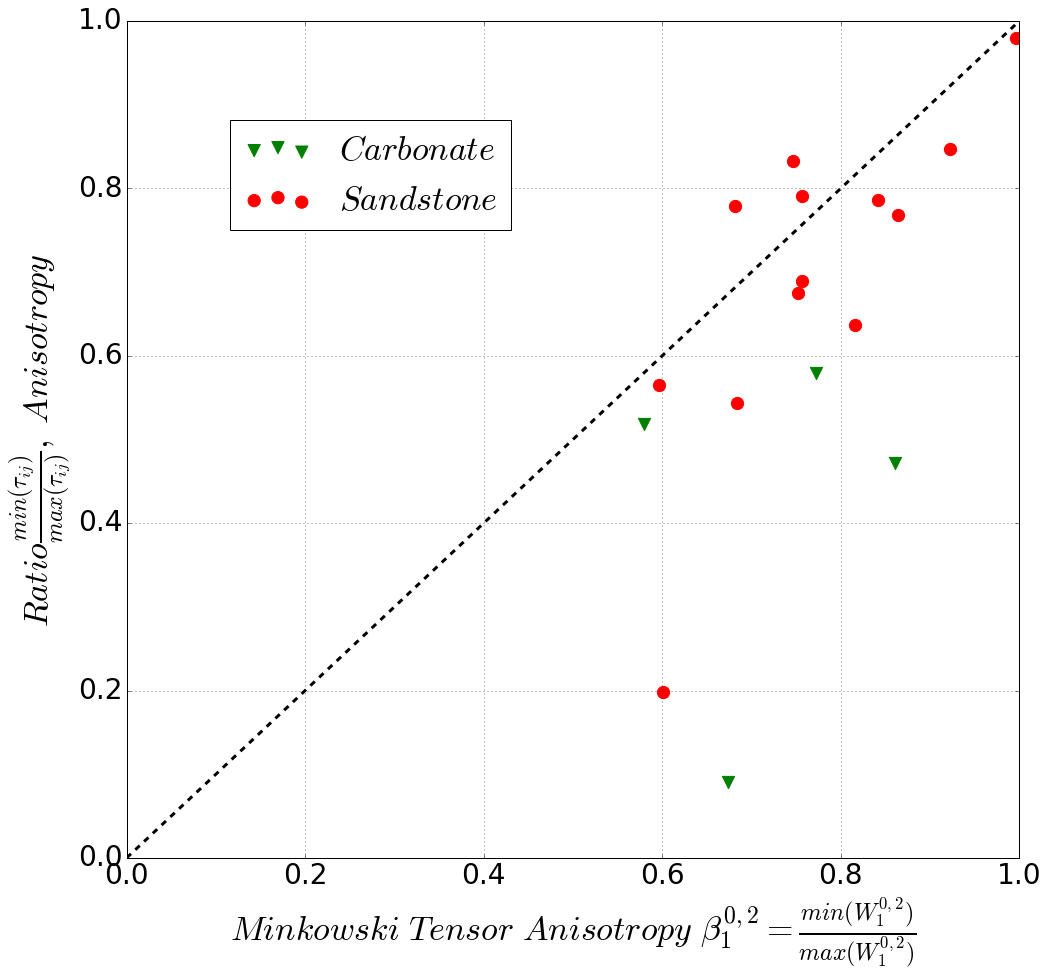

In [61]:
fig, ax = plt.subplots(figsize=(16,15))

#ax.set_yscale("log")
ax.set_xlim(0, 1.0)
ax.set_ylim(0.0, 1.0)

#ax.set_title(r'$Anisotropy \ Indices \ \beta_{1}^{0,2}, \ \beta_{2}^{0,2}  \ versus \ Window \ Size \ r$', fontsize=22, y=1.02)#

ax.set_xlabel(r'$Minkowski \ Tensor \ Anisotropy \ \beta_{1}^{0,2}=\frac{min(W_{1}^{0,2})}{max(W_{1}^{0,2})}$', fontsize=34)
ax.set_ylabel(r'$Ratio \frac{min(\tau_{ij})}{max(\tau_{ij})}, \ Anisotropy$', fontsize=34)

plt.grid()

for por, rat, name in zip(minkowski_ratio, ratio, samples_names_label):
    color = "red"
    if name in ["ketton", "estaillades", "C1", "C2"]:
        color = "green"
        marker = "v"
    else:
        marker = "o"
    if name == "estaillades":
        ax.scatter(por, rat, color=color, s=150, label=r"$Carbonate$", marker=marker)
    elif name == "doddington":
        ax.scatter(por, rat, color=color, s=150, label=r"$Sandstone$", marker=marker)
    else:
        ax.scatter(por, rat, color=color, s=150, marker=marker)
for i, (item) in enumerate(ax.get_xticklabels()):
    item.set_fontsize(28)

for i, (item) in enumerate(ax.get_yticklabels()):
    item.set_fontsize(28)
    
    
ax.plot(np.linspace(0, 1., 100), np.linspace(0, 1., 100), color="black", linestyle="--", linewidth=3)

legend = plt.legend(bbox_to_anchor=(0., 0.8, 0.45, .102), fontsize=34)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
fig.savefig("permeability_results/MT_anisotropy_vs_Tortuosity_Anisotropy.png", bbox_extra_artists=(legend,), bbox_inches='tight', dpi=300)
print spearmanr(minkowski_ratio, ratio)
plt.show()

In [13]:
from ggplot import *
import pandas as pd
import matplotlib

In [62]:
min_to_mean_ratios = np.array([min_perm/average_perm for min_perm, average_perm in zip(min_perms, average_perms)])
min_to_mean_ratios_sorted = np.array(sorted(min_to_mean_ratios))

measured_permeability_ratios_sorted = sorted(measured_permeability_ratios)
labels_min_max_perm_sorted = [x for (y,x) in sorted(zip(measured_permeability_ratios, samples_names_label))]

labels_sorted = np.array([x for (y,x) in sorted(zip(min_to_mean_ratios, samples_names_label))])
labels_minkowski_anisotropy_sorted = np.array([x for (y,x) in sorted(zip(minkowski_ratio, samples_names_label))])
minkowski_ratio_sorted = sorted(minkowski_ratio)
ggplot_data = pd.DataFrame({"Sample Name": labels_sorted, "Deviation from Isotropy": min_to_mean_ratios_sorted})
print labels_sorted

['C2' 'S3' 'estaillades' 'C1' 'S1' 'ketton' 'S9' 'S4' 'S7' 'S2'
 'bentheimer' 'doddington' 'Berea' 'S5' 'S6' 'S8' 'beadpack']


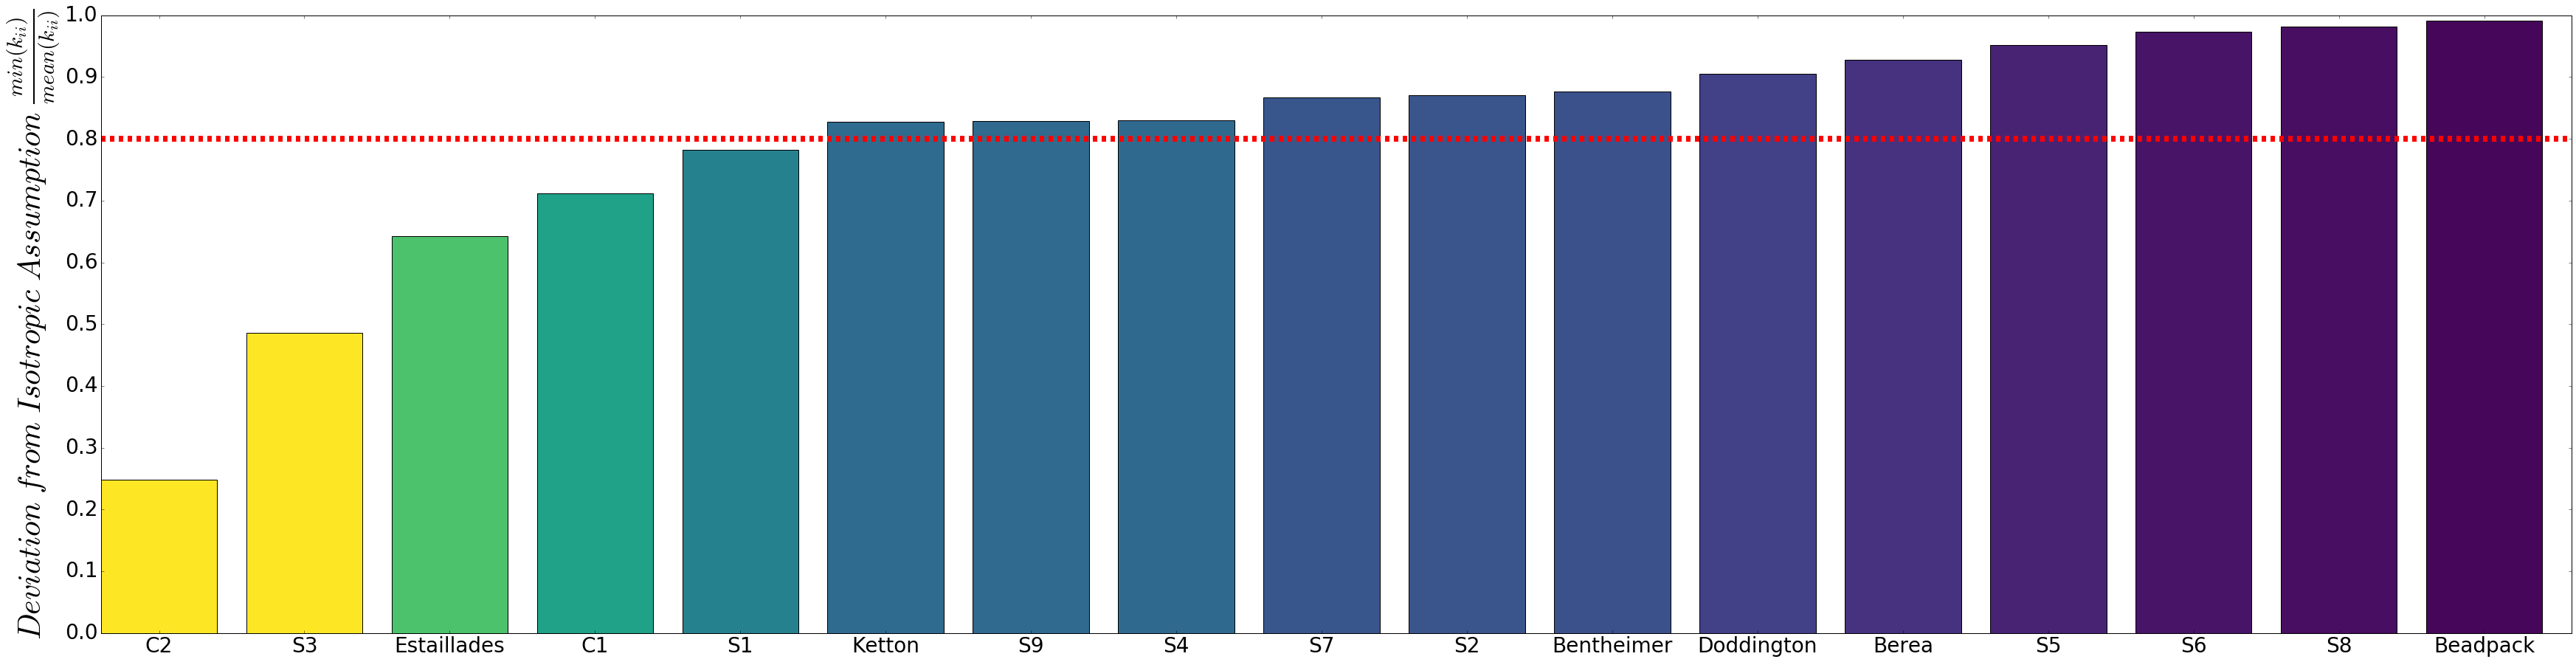

In [73]:
fig, ax = plt.subplots(figsize=(60,15))


norm = matplotlib.colors.Normalize(vmin=0.5, vmax=1.0)#min(min_to_mean_ratios_sorted), vmax=max(min_to_mean_ratios_sorted))
cmap = matplotlib.cm.get_cmap('viridis_r')

N = len(labels_sorted)
ax.set_xlim(0, N)
ind = np.arange(N)    # the x locations for the groups
width = 0.8    # the width of the bars: can also be len(x) sequence

p1 = ax.bar(ind, min_to_mean_ratios_sorted, width, color=[cmap(norm(val)) for val in min_to_mean_ratios_sorted])
ax.set_ylabel(r'$Deviation \ from \ Isotropic \ Assumption \ \frac{min(k_{ii})}{mean(k_{ii})}$', size=42)
#plt.title('Scores by group and gender')

# major ticks every 20, minor ticks every 5                                      
major_ticks = np.linspace(0., 1.0, 11)                                                                                            

#print labels_sorted
plt.xticks(ind + width/2., [val.title() for val in labels_sorted])
plt.yticks(major_ticks, [str(val) for val in major_ticks])
ax.axhline(0.80, linestyle="--", linewidth=8, color="red")
for item, label in zip(ax.get_xticklabels(), labels_sorted):
    item.set_fontsize(28)
    item.set_label(label)

#ax.set_yticks(major_ticks)  

for i, (item) in enumerate(ax.get_yticklabels()):
    item.set_fontsize(28)
fig.savefig("permeability_results/Min_to_Mean_Measured_Permeability.png", bbox_extra_artists=None, bbox_inches='tight', dpi=300)

plt.show()

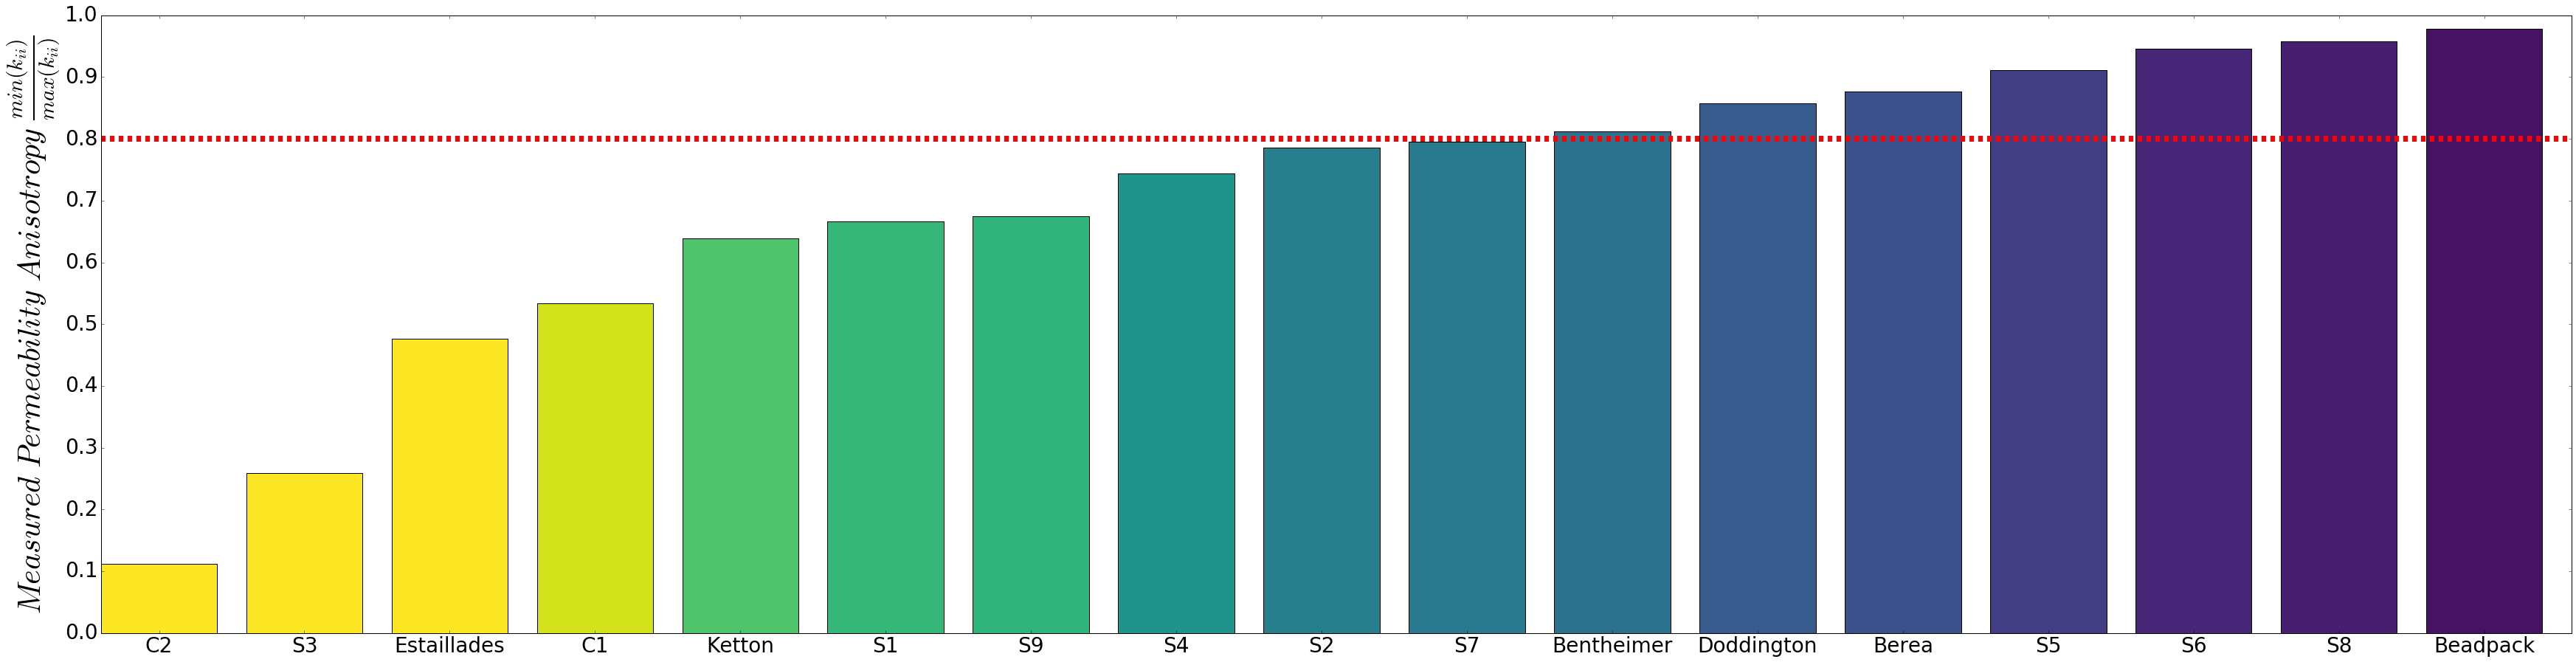

In [74]:
labels=labels_min_max_perm_sorted
data_vals = measured_permeability_ratios_sorted

fig, ax = plt.subplots(figsize=(60,15))


norm = matplotlib.colors.Normalize(vmin=0.5, vmax=1.0)#min(data_vals), vmax=max(data_vals))
cmap = matplotlib.cm.get_cmap('viridis_r')

N = len(labels)
ax.set_xlim(0, N)
ind = np.arange(N)    # the x locations for the groups
width = 0.8     # the width of the bars: can also be len(x) sequence

p1 = ax.bar(ind, data_vals, width, color=[cmap(norm(val)) for val in data_vals])
ax.set_ylabel(r'$Measured \ Permeability \ Anisotropy \ \frac{min(k_{ii})}{max(k_{ii})}$', size=42)
#plt.title('Scores by group and gender')
plt.xticks(ind + width/2., [val.title() for val in labels])
#plt.yticks(np.arange(0, 81, 10))
# major ticks every 20, minor ticks every 5                                      
major_ticks = np.linspace(0., 1.0, 11)                                                                                            

plt.yticks(major_ticks, [str(val) for val in major_ticks])
ax.axhline(0.80, linestyle="--", linewidth=8, color="red")

for item, label in zip(ax.get_xticklabels(), labels):
    item.set_fontsize(28)
    item.set_label(label)

for i, (item) in enumerate(ax.get_yticklabels()):
    item.set_fontsize(28)
fig.savefig("permeability_results/Min_to_Max_Measured_Permeability.png", bbox_extra_artists=None, bbox_inches='tight', dpi=300)

plt.show()

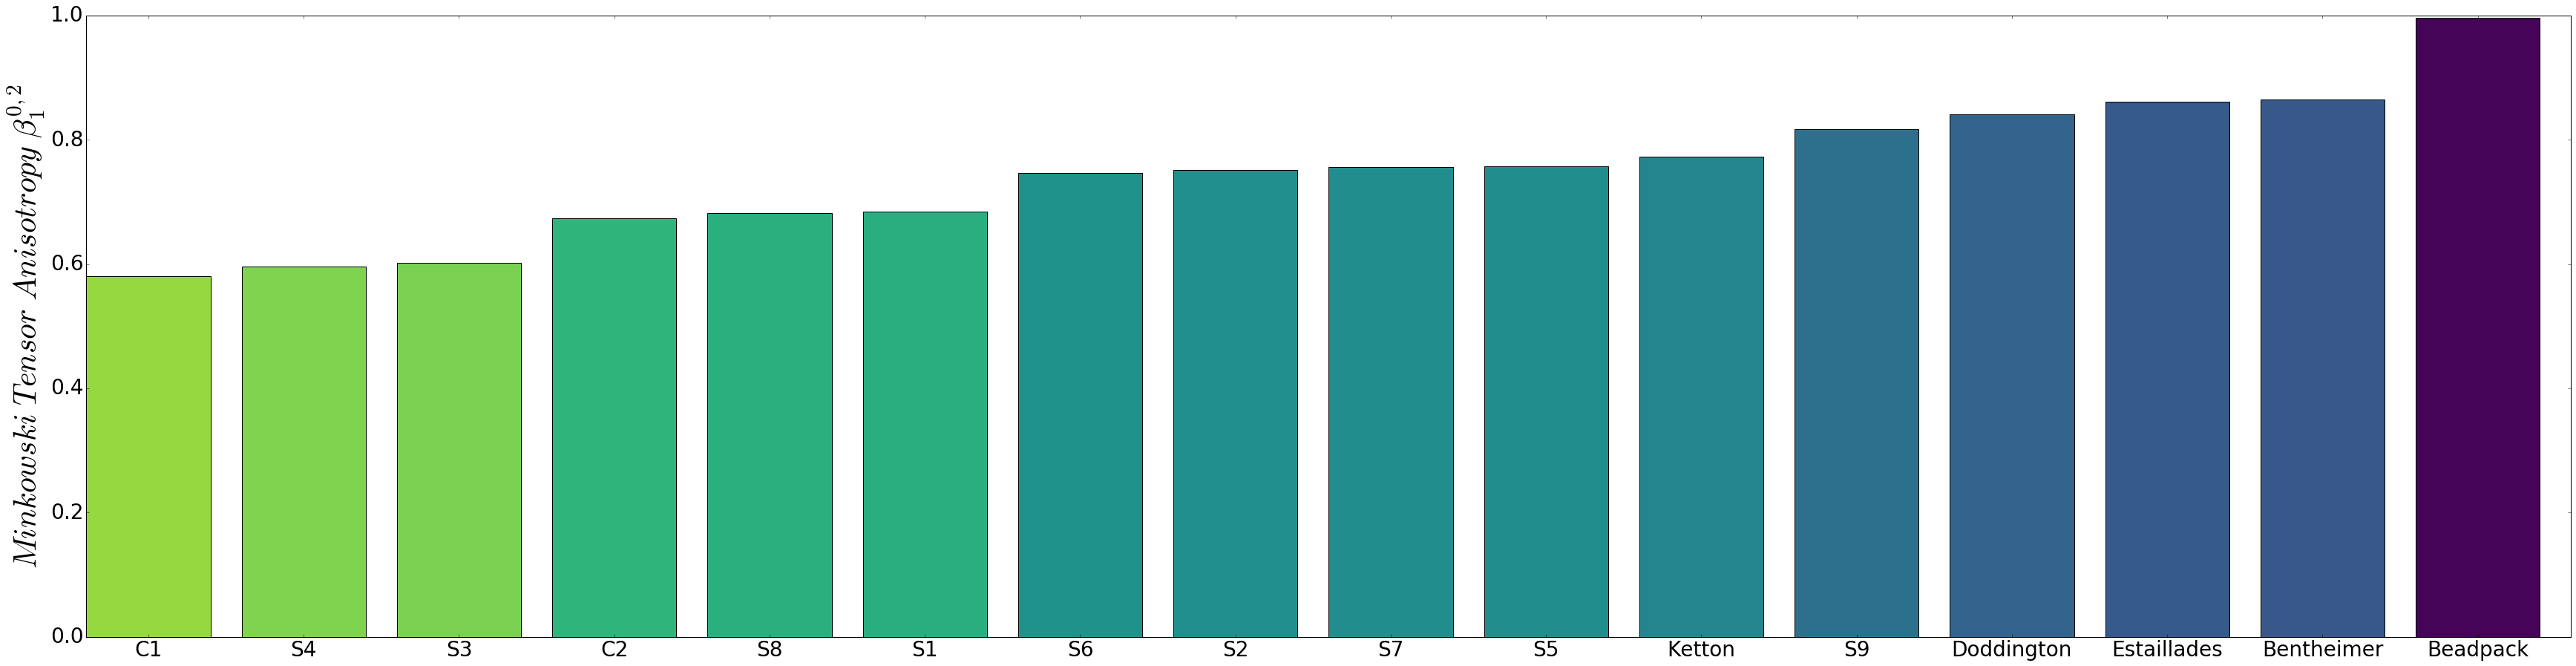

In [16]:
labels=labels_minkowski_anisotropy_sorted
data_vals = minkowski_ratio_sorted

fig, ax = plt.subplots(figsize=(60,15))


norm = matplotlib.colors.Normalize(vmin=0.5, vmax=1.0)#min(data_vals), vmax=max(data_vals))
cmap = matplotlib.cm.get_cmap('viridis_r')

N = len(labels)
ind = np.arange(N)    # the x locations for the groups
width = 0.8     # the width of the bars: can also be len(x) sequence

p1 = ax.bar(ind, data_vals, width, color=[cmap(norm(val)) for val in data_vals])
ax.set_ylabel(r'$Minkowski \ Tensor \ Anisotropy \ \beta_{1}^{0,2}$', size=42)
#plt.title('Scores by group and gender')
plt.xticks(ind + width/2., [val.title() for val in labels])
#plt.yticks(np.arange(0, 81, 10))

for item, label in zip(ax.get_xticklabels(), labels):
    item.set_fontsize(28)
    item.set_label(label)

for i, (item) in enumerate(ax.get_yticklabels()):
    item.set_fontsize(28)

fig.savefig("permeability_results/Minkowski_Tensor_Anisotropy.png", bbox_extra_artists=None, bbox_inches='tight', dpi=300)


plt.show()